In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import contractions
from tqdm import tqdm

spacy.prefer_gpu()
en_model = spacy.load('en_core_web_md')
data = pd.read_csv('news_summary_more.csv',encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [2]:
def clean_text(text):
    toks = text.lower().split()
    toks = [contractions.fix(t) for t in toks]
    toks = en_model(" ".join(toks))
    toks = [str(t) for t in toks if (not t.is_punct) and (str(t)!="'s")]
    return " ".join(toks)

data['clean_headlines'] = data.headlines.apply(lambda x: "<sos> " + clean_text(x) + " <eos>")
data['clean_text'] = data.text.apply(lambda x: clean_text(x))


In [3]:
data['headlines_wf'] = data.clean_headlines.apply(lambda x: len(x.split()))
data['text_wf'] = data.clean_text.apply(lambda x: len(x.split()))

array([[<AxesSubplot: title={'center': 'headlines_wf'}>,
        <AxesSubplot: title={'center': 'text_wf'}>]], dtype=object)

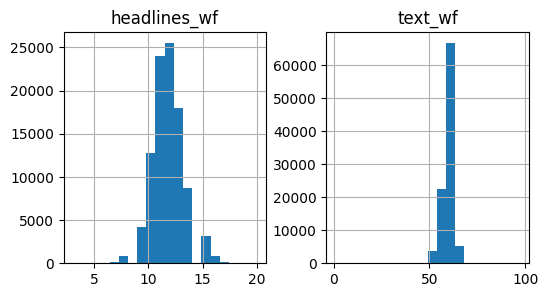

In [4]:
data.hist(figsize=(6,3),bins=20)

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def non_rare_word_count(data,thresh=4):
    tk = Tokenizer()
    tk.fit_on_texts(data)
    count = np.array(list(dict(tk.word_counts).values()), dtype='int32')
    words = np.array(list(tk.word_counts), dtype='object')
    rare_words = len([i for i in range(len(words)) if count[i] < thresh])
    return len(tk.word_counts) - rare_words

text_wc = non_rare_word_count(data.clean_text)
headlines_wc = non_rare_word_count(data.clean_headlines)

In [6]:
text_maxlen = max([len(x.split()) for x in data.clean_text])
headlines_maxlen = max([len(x.split()) for x in data.clean_headlines])

In [7]:
xtk = Tokenizer(num_words = text_wc)
xtk.fit_on_texts(data.clean_text)
seq = xtk.texts_to_sequences(data.clean_text)
x_padded = pad_sequences(seq,maxlen=text_maxlen,padding='post')
x_voc = xtk.num_words+1

ytk = Tokenizer(filters='',num_words=headlines_wc)
ytk.fit_on_texts(data.clean_headlines)
seq = ytk.texts_to_sequences(data.clean_headlines)
y_padded = pad_sequences(seq,maxlen=headlines_maxlen,padding='post')
y_voc = ytk.num_words+1

In [8]:
x_voc,y_voc

(34842, 15398)

In [9]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

xtrain,xtest,ytrain,ytest = train_test_split(x_padded,y_padded,train_size=0.8)

dataset = (xtrain,xtest,ytrain,ytest)

In [10]:
import pickle

def save_variable(var,name):
    with open(name+'.pkl','wb') as f:
        pickle.dump(var,f)
        
save_variable(xtk,'xtk')
save_variable(ytk,'ytk')
save_variable(dataset,'data')

    